<a href="https://colab.research.google.com/github/grniemeyer/DLfNLP/blob/main/ASSIGNMENT_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words Text Classification

In this assignment we will build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on a Twitter dataset (with given labels) and is supposed to identify if the sentiment in individual tweets is *positive* or *negative*.


## Concepts covered in this assignment
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. Build a simple feed-forward neural net classifier using PyTorch
4. Training the model

As always, we start with some imports...




In [1]:
import random
import re # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import google_drive_downloader
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


device(type='cuda')

Next, we load our dataset.

In [2]:
DATA_PATH = 'data/twitter_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='13OLqDXOBAO9fjD9Shz8iTeev3ZaNHaTC',
        dest_path=DATA_PATH,
    )

df = pd.read_csv(DATA_PATH)

**Let's see what we are working with...**

In [3]:
print('Shape of the dataset' )
print(df.shape)

Shape of the dataset
(1000000, 3)


Below is a sample set of five random tweets and their classifications. The classifications are labeled "1" for positive and "0" for negative tweets.

In [4]:
df.sample(5)

,Unnamed: 0,tweet,label
955395,955395,Just got home... had great fun with Amy and Mi...,1
670350,670350,"For gadget dad, visit Iwoot for loads of fathe...",1
215530,215530,@jayedotcom I'm sad bout it,0
596234,596234,"@angelazuri89 No, you don't understand...she's...",0
780332,780332,Great Rain! At 9am,0


Let's see the distribution of positive and negative tweets. This is the data our classifier will be trained on later.

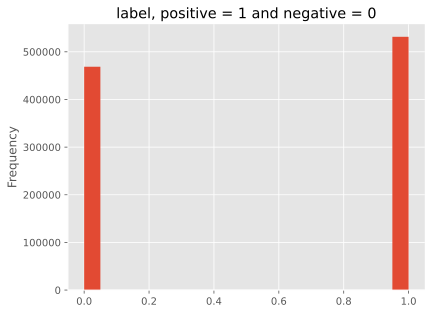

In [5]:
df['label'].plot(kind='hist', bins=20, title='label, positive = 1 and negative = 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

How about looking at specific examples for each class?

In [6]:
print('Example negative tweet:')
print(df.loc[55,].tweet, '\n')
print('Example positive tweet:')
print(df.loc[12456,].tweet, '\n')

Example negative tweet:
  David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.  

Example positive tweet:
*sigh*  sweet dreams guys...... 



Looking at your data before starting to code will help you in the process for example when encountering errors, when the training does not improve, or when you simply want to understand your results in the end. Remember: a good DL model is only as good as the data we feed it with!

# 1. Preprocessing
(2.5 Points - 0.5 for each subtask)<br>

As in the last assignment, we need to transform our data before training our classifier on it. We are interested to do the following preprocessing steps:
* Replace weird characters
* Lowercase
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below we constructed a simple test tweet.**

In [1]:
test_corpus = '''Curtain drops at the #Crown Uptown after 32 years http://www.kansas.com/news/featured/story/860875.html'''

<h1>Exercise 1.1</h1>
Write a function `special_and_lower` that removes special characters and puts the text lowercase. If you wonder what a special character is, check [here](https://www.computerhope.com/jargon/s/specchar.htm)


In [2]:
# Your answer goes here
def special_and_lower(text):
  ''' removes punctuation/"weird" characters, numbers? and returns text in lowercase letters'''
  punct_marks = '!()-[]{};:\'"\,<>./?@#$%^&*_~' # except dots, in order to be able to split into sentences later
  cleaned_text = ""

  for l in text:
      if l not in punct_marks:
        cleaned_text += l

  # to lowercase
  cleaned_lower_text = []
  cleaned_lower_text = cleaned_text
  text = [word.lower() for word in text]


  # text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  # text = text.lower()
  # return text

  return cleaned_lower_text



test_corpus_sl = special_and_lower(test_corpus)
print(test_corpus_sl)
print(type(test_corpus))

Curtain drops at the Crown Uptown after 32 years httpwwwkansascomnewsfeaturedstory860875html
<class 'str'>


<h1>Exercise 1.2</h1>Write a function `tokenize_text` that creates a list of tokens from the input text. Use your own implementation here.

In [3]:
# Your answer goes here
def tokenize_text(text):
  # Split the string into a list of strings based on spaces and punctuation
  list_of_strings = re.split(r'\s+|[.,;!?()]', text)

  # Filter out empty strings from the result
  list_of_strings = [token for token in list_of_strings if token]

  return list_of_strings


  # # with NLTK wordpunct_tokenize function
  # tokens = wordpunct_tokenize(text)
  # return tokens


test_corpus_t = tokenize_text(test_corpus_sl)
print(test_corpus_t)
print(type(test_corpus_t[0]))

NameError: ignored

<h1>Exercise 1.3</h1>

Using  **WordNetLemmatizer** , write a function `lemmatize_text` that lemmatizes the text. Lemmatization, which is the process of grouping inflected forms together as a single base form, is a text normalization that is used in pre-processing. Please lemmatize first nouns and then verbs. For more information regarding *WordNetLemmatizer*, please check [here](https://www.nltk.org/_modules/nltk/stem/wordnet.html):


In [ ]:
# Your answer goes here
def lemmatize_text(tokens):
  # lemmatizer = WordNetLemmatizer()
  # lem_n = lemmatizer.lemmatize(text, "n")
  # lem_n_v = lemmatizer.lemmatize(lem_n, "v")
  # return lem_n_v

  lemmatizer = WordNetLemmatizer()

  # Lemmatize nouns first and then verbs
  lemmatized_tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in lemmatized_tokens]

  return lemmatized_tokens


test_corpus_l = lemmatize_text(test_corpus_t)
print(test_corpus_l)

<h1>Exercise 1.4 </h1>Write a function `replace_numbers` that replaces any standalone number with the special token " < NUM > " (without the spaces). For instance, "42" must be replaced by the token but "42h" not.




In [ ]:
# Your answer goes here

# appently not working first version:
# def replace_numbers(text):
#   text = re.sub(r'\b\d+\b', '<NUM>', text)
#   return text


# test_corpus_r = replace_numbers(test_corpus_l)
# print(test_corpus_r)


In [ ]:
# alternative version to also cover strings according to error message:

def replace_numbers(text_or_tokens):
    if isinstance(text_or_tokens, str):
        # if input is string, tokenize it first
        tokens = wordpunct_tokenize(text_or_tokens)
    elif isinstance(text_or_tokens, list):
        # if input is already a list of tokens, use it directly
        tokens = text_or_tokens
    else:
        raise ValueError("Input must be a string or a list of tokens.")

    tokens_with_replaced_numbers = ['<NUM>' if token.isdigit() else token for token in tokens]

    # join tokens back into a string
    text_with_replaced_numbers = ' '.join(tokens_with_replaced_numbers)

    return text_with_replaced_numbers


test_corpus_n = replace_numbers(test_corpus_l)
print(test_corpus_n)

<h1>Exercise 1.5</h1>We want to remove redundant words that are very common in all the texts (like "a" or "to"). As you learned previously, these words are called stopwords and do not contain any meaning, that is relevant for our task.
Write a function "remove_stopwords" that removes stopwords using the stopwords imported from NLTK (check on top).

In [ ]:
# Your answer goes here
# def remove_stopwords(text):

#   stop_words = set(stopwords.words('english'))
#   tokens_w_stop_words = wordpunct_tokenize(text)
#   without_stop_words = []

#   for word in tokens_w_stop_words:
#     if word not in stop_words:
#       without_stop_words.append(word)

#   return without_stop_words

stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words):
    #stop_words = set(stopwords.words('english'))

    # regexp pattern to tokenize while preserving '<NUM>'
    custom_pattern = r'\b\w+\b|<NUM>'

    # tokenize text
    tokens_w_stop_words = re.findall(custom_pattern, text)

    # filter out stop words
    without_stop_words = [word for word in tokens_w_stop_words if word not in stop_words]

    return without_stop_words


test_corpus_s = remove_stopwords(test_corpus_n, stop_words)
print(test_corpus_s)
print(type(test_corpus_s))

# 2. Building a Vocabulary

Next we want to create some sort of represention for our tokens. As you encountered in the lecture, one way of doing this is by representing words by unique values and store them in a vocabulary. You will learn later why such a representation (or embedding) is not very efficient for larger text corpora. For the task at hand it is sufficient however.

<h1>Exercise 2.1</h1> (2 Points)<br> Define the function `build_vocab` which receives as input `clean_tokens` and returns `vocab`, which is a python dictionary with words as keys and unique integer indices as values.



In [14]:
# Your answer goes here
from itertools import chain
def build_vocab(clean_tokens):

    #make sure clean_tokens is not a nested list which is "unhashable" which is what Counter needs
    clean_tokens = list(chain.from_iterable(clean_tokens))
    word_counts = Counter(clean_tokens)

    #vocabulary dictionary with unique integer indices for each word
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}

    return vocab


print(build_vocab([test_corpus_s]))

{'Curtain': 0, 'drop': 1, 'Crown': 2, 'Uptown': 3, '<NUM>': 4, 'year': 5, 'httpwwwkansascomnewsfeaturedstory860875html': 6}


<h1>Exercise 2.2 </h1>(2 Points)<br> Define the function `build_index2token` which receives as input `vocab` (the output of the previously defined function `build_vocab`) and returns `index2token`, which is a python dictionary with unique integer indices as keys and  words as values. Make sure that the indices assigned to the words are exactly the same as in `vocab`.


In [15]:
# Your answer goes here
# why not directly define it like this in build_vocab..??
def build_index2token(vocab):
  index2token = {idx: word for word, idx in vocab.items()}
  return index2token


print(build_index2token(build_vocab([test_corpus_s])))

{0: 'Curtain', 1: 'drop', 2: 'Crown', 3: 'Uptown', 4: '<NUM>', 5: 'year', 6: 'httpwwwkansascomnewsfeaturedstory860875html'}


**Let's package the pre-processing steps together into one function to later apply it to our dataset.**<br>
(1 Point)



In [16]:
def tokenize(text):
    # Complete this function by sending the data (text) through each of the functions you built above (special_and_lower, tokenize_text, replace_numbers, remove_stopwords, lemmatize text).
    # Think carefully about a sensible order!
    # above cell order: special_lower, tokenize, lemmatize, replace numbers, remove_stopwords -> which works!
    text_special_lower = special_and_lower(text)
    tokens = tokenize_text(text_special_lower)
    text_tokens_replaced_numbers = replace_numbers(tokens)
    tokens_no_stopwords = remove_stopwords(text_tokens_replaced_numbers, stop_words)
    tokens_lemmatized = lemmatize_text(tokens_no_stopwords)

    return tokens_no_stopwords

print(tokenize(test_corpus))

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

['Curtain', 'drops', 'Crown', 'Uptown', '<NUM>', 'years', 'httpwwwkansascomnewsfeaturedstory860875html']


# 3. Splitting and transforming the Dataset

<h1>Exercise 3.1</h1>
(3 points)

In this part, we will build a class to assign our data to. It helps us to easier access different parts of our dataset. But before doing so, we want you to do something else. Go to the `TwitterDataset` class and implement a function that assigns to the variable `common_tokens` the `n` most frequent/used words accross all tokens. `n` in this case is denoted as `max_vocab`.<br>

Make sure to use a function that compresses the output to a set of unique words, ie. disregard dublicates. If you're done with that, come back up here!

Next, we want you to implement a function `remove_rare_words` that will be called in the `TwitterDataset` class to remove rare words from each sequence of tokens in our dataset. As you can see, the function takes two arguments: a list of tokens, and a set of common_tokens (which is the variable you just filled in the previous task).

(1 point)

In [17]:
def remove_rare_words(tokens, common_tokens):

    ''' input: list = tokens, set = common_tokens
    output: a list with only those tokens that can also be found among the most common tokens. all rare words are to be replaced with '<UNK>' '''
    # Your answer goes here
    without_rare_words = [token if token in common_tokens else '<UNK>' for token in tokens]

    return without_rare_words

Now we would like you to implement a function called `common_tokens`, that is called inside the class `TwitterDataset` and takes `all_tokens` to then return a set of most common words. The length of the set should be limited by the parameter `max_vocab`.

In [18]:
def get_common_tokens(all_tokens, max_vocab):
    # frequency of each token
    token_counts = Counter(all_tokens)

    # selects top max_vocab tokens based on frequency
    common_tokens = [token for token, _ in token_counts.most_common(max_vocab)]

    return set(common_tokens)

(1 point)

In [19]:
class TwitterDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000):
        df = pd.read_csv(data_path)
        #df = df.iloc[:df.shape[0]//20]
        df = df[:15000]

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.tweet.apply(
            partial(
                tokenize,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # This is where your function will be called
        common_tokens = get_common_tokens(all_tokens, max_vocab)

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        self.token2idx = build_vocab(list(df.tokens))
        self.idx2token = build_index2token(self.token2idx)


        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        self.text = df.tweet.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

**Question**: Why might removing rare words not be a good idea? Why or when could rare words be valuable?

(1 point)

**Your answer goes here:** Rare words are not necessariliy unimportant to text analysis in NLP, especially when dealing with texts about very specific topics with a lot of "jargon" words. In such cases these "rare" words might be quite valuable for the sentiment analysis/evaluation. Other cases might be names that could be important for example in evaluations of avertisements.

Finally, we can instantiate our dataset.

In [20]:
MAX_VOCAB = "500" #@param [1000, 5000, 10000, 100000] {allow-input: true}

MAX_VOCAB = int(MAX_VOCAB)

In [21]:
# This will load for a while: Grab a coffee
dataset = TwitterDataset(DATA_PATH, max_vocab=MAX_VOCAB)

100%|██████████| 14984/14984 [00:00<00:00, 151997.45it/s]


Again, we can check a random sample out of the dataset.

In [22]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('label:', sample_target, '\n')

Number of records: 14984 

index: 4853 

#doyourememberwhen myspace first started out...it was pretty lame. YEAH i remember that shit. i'm a fuckin nerd  

[4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 9, 11, 10, 0, 24, 3, 0, 24, 1, 10, 24, 12, 2, 3, 4, 5, 6, 7, 8, 3, 25, 10, 12, 24, 24, 18, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 10, 12, 15, 12, 15, 29, 12, 10, 3, 0, 27, 11, 24, 3, 11, 15, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8] 

BoW vector size: 55 

label: 1 



<h1>Exercise 3.2</h1> (2 Points)<br> Split into training, validation, and test sets.

Since we only have a certain ammount of Data to train, validate and test our model on, we need to split our Dataset into 3 Parts:

- **Training**: data the model learns from (80%)
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!) (10%)
- **Testing**: data to evaluate the final performance of the model (10%)

Given the ratios for validation and testing, it is your task to complete the `function split_train_valid_test` and calculate the three split lenghts, which are then used as argument in the `random_split` function we have imported at the top of this notebook.

In [23]:
# Please complete this
def split_train_valid_test(dataset, valid_ratio=0.1, test_ratio=0.1):
    total_length = len(dataset)

    valid_length = int(valid_ratio * total_length)
    test_length = int(test_ratio * total_length)
    train_length = total_length - valid_length - test_length

    # with random_split create training, validation, and testing sets
    train_set, valid_set, test_set = random_split(dataset, [train_length, valid_length, test_length])

    return train_set, valid_set, test_set


In [24]:
# Now we apply the function above:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

#print(train_dataset, valid_dataset, test_dataset)

(13486, 749, 749)

Next up: **Batching**. Since our classifier can only work on a certain amount of data at a time and we dont have endless amounts of RAM available, we will use batching to split our dataset into mouth-sized bites.

In [25]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    target = torch.LongTensor([item[2] for item in batch])
    text = [item[3] for item in batch]
    return seq, bow, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

After splitting our data it now looks like this:

In [26]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')


number of training batches: 26 

Training input sequence: [4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 32, 3, 4, 5, 6, 7, 8] 

BoW vector size: 55 

Label:  tensor(1) 

Review text: #youtube - Souljaboy - Crank that  iwie verarsche =D http://cli.gs/Se6MV1 



# 4. BoW Model

So, now to the fun part. In the following, we are going to construct our classifier to the actual job of predicting positive or negative tweets. Every step will take you through a different phase of building our model.

### Building the BoW Model

![BOW](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/bow_representation.png?raw=1)

In the cell below 4.1 we implemented a BoW-Model with the following specifics:
- Input: BoW Vector
- Model:
    - feed-forward fully connected network
    - 2 hidden layers
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

<h1>Exercise 4.1 </h1> (2 Points)<br> Substitute the three non-linear functions which are currently of type `relu` with any other type you like. You may want to experiment with several types and then leave you favourite in the final solution. Check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for the available non-linear functions in Pytorch.

In [41]:
#version 2
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, hidden3, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        # Here we instantiate the different layers of our network
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc5 = nn.Linear(hidden3, num_labels)

    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        # Here we feed our data through our neural network
        # Please send them through each layer one my one.
        x = torch.FloatTensor(x)
        x = (self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        x = self.fc5(x)
        return x

<h1>Exercise 4.2</h1>
(not scored)<br> Play with HIDDEN1 and HIDDEN2 parameters. Try to find which parameter configuration leads to better classification performance. The number below influences the amount of Neurons per Layer.

In [42]:
# Define hidden layer size
HIDDEN1 = "30" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = "50" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN3 = "100" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

LEARNING_RATE = "0.000001" #@param [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.00000001] {allow-input: true}
criterion = nn.CrossEntropyLoss() # try out different loss functions here. read the documenation for more.

HIDDEN1 = int(HIDDEN1)
HIDDEN2 = int(HIDDEN2)
HIDDEN3 = int(HIDDEN3)
LEARNING_RATE = float(LEARNING_RATE)

<h1>Exercise 4.3</h1> (2 Points) <br> Add an extra hidden layer to the network, with a size of your choice. You can do it by modifying the cell below and of course adjusting the Class definition of `FeedfowardTextClassifier` such that it accepts one more layer when initialized.

In [43]:
# Initializing the model.
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    hidden3 = HIDDEN3,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)

bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=55, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=2, bias=True)
)

In [44]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([30, 55])
torch.Size([30])
torch.Size([50, 30])
torch.Size([50])
torch.Size([100, 50])
torch.Size([100])
torch.Size([2, 100])
torch.Size([2])


### Training the BoW Model

Theoretically, our model now looks like this. You have seen these mathematical formulas in the lecture and the tutorial.


Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient:
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

**Define a loss function, a gradient descent optimizer, and a scheduler.**

- Criterion: compute *Loss* to see how much the prediction does differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily the global minimum is reached.
- Scheduler: dynamic alteration of the learning rate

**Question**: When selecting optimizers, you can think about what problems we may run into when performing gradient desent? (hint: global minimum vs. local minimum) <br>
(0.5 points)

**Your answer goes here:** We need an optimizer that prevents the gradient descent to get stuck in local minima (overfitting, learning the noise). For example some optimizers use random sampling to "explore" the gradient landscape and ideally find a path to the global minimum.

In [45]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round** <br>
Nothing to do here, just run the cell.

In [46]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += 1

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += 1

    return total_loss / total

And after all the construction work, we can now finally **train our classifier!**

In [47]:
n_epochs = 0
max_epochs =100
train_losses, valid_losses = [], []
while n_epochs <= max_epochs:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  2	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  3	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  4	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  5	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  6	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  7	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  8	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch #  9	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 10	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 11	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 12	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 13	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 14	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 15	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 16	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 17	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 18	train_loss: 6.92e-01	valid_loss: 6.91e-01

epoch # 19	train_loss: 6.92e

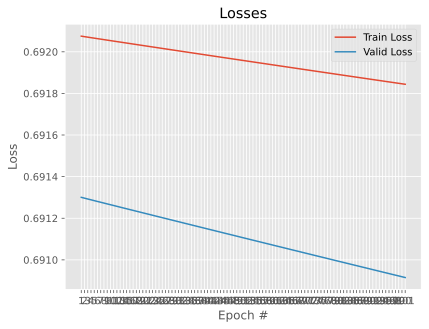

In [48]:
# This plot will visualize the model's loss over the epochs it was trained for.
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# 4.4. Understanding of the impact of layers and different parameters.

  - In this section you will explore the impact of hidden layers, the number of neurons in each hidden layer, the learning rate and loss functions. We will produce the training and validation losses to compare the graphs of different combinations to build up a deeper understanding of how all these parameters can have an impact on the overall classification performance.

  -  You are welcome to create your own number of hidden layers, experiment with it and observe the changes in the training and validation losses. In that case, don't forget to change the bow_model and FeedfowardTextClassifier class as well.

In [50]:
# This exercise will take some time. Have patience.

HIDDEN_1 = [64, 128, 128] # change your parameters here
HIDDEN_2 = [128, 128, 256] # change your parameters here
HIDDEN_3 = [128, 512, 64] # change your parameters here

LEARNING__RATE = [0.01, 0.001, 0.00001] # change your parameters here
max_epochs =[50,50,50] # change your parameters here, you can keep the epocs same to comare the results for different set of experiments.

criterion = nn.CrossEntropyLoss() # try out different loss functions here. read documentaion for more

combination = 3
results = []

for i in range(combination) :
  print(f'training model for {i} combination of parameters.')

  HIDDEN1 = HIDDEN_1[i]
  HIDDEN2 = HIDDEN_2[i]
  HIDDEN3 = HIDDEN_3[i]
  LEARNING_RATE = LEARNING__RATE[i]

# Store results for each run

  # Initialize the model with current parameters
  bow_model = FeedfowardTextClassifier(
      vocab_size=len(dataset.token2idx),
      hidden1=HIDDEN1,
      hidden2=HIDDEN2,
      hidden3 = HIDDEN3,
      num_labels=2,
      device=device,
      batch_size=BATCH_SIZE,
  )

  # Convert learning_rate to float
  learning_rate = float(LEARNING_RATE)

  optimizer = optim.Adam(
      filter(lambda p: p.requires_grad, bow_model.parameters()),
      lr=learning_rate,
  )
  scheduler = CosineAnnealingLR(optimizer, 1)
  def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += 1

    return total_loss / total


  def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total +=1

    return total_loss

  n_epochs = 0
  train_losses, valid_losses = [], []
  while n_epochs <= max_epochs[i]:
      train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
      valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

      tqdm.write(
          f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
      )

      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      n_epochs += 1

  # Store the results for this run
  result_entry = {
      'combination': f' hidden1 = {HIDDEN1}, hidden2 = {HIDDEN2}, hidden3 = {HIDDEN3},\n  learning_rate = {LEARNING_RATE}, and epoch = {max_epochs[i]}'  ,
      'learning_rate': learning_rate,
      'max_epochs': max_epochs,
      'train_losses': train_losses,
      'valid_losses': valid_losses,
  }

  results.append(result_entry)

training model for 0 combination of parameters.
epoch #  1	train_loss: 6.80e-01	valid_loss: 1.33e+00

epoch #  2	train_loss: 6.64e-01	valid_loss: 1.28e+00

epoch #  3	train_loss: 6.52e-01	valid_loss: 1.27e+00

epoch #  4	train_loss: 6.43e-01	valid_loss: 1.26e+00

epoch #  5	train_loss: 6.39e-01	valid_loss: 1.25e+00

epoch #  6	train_loss: 6.33e-01	valid_loss: 1.25e+00

epoch #  7	train_loss: 6.30e-01	valid_loss: 1.24e+00

epoch #  8	train_loss: 6.26e-01	valid_loss: 1.23e+00

epoch #  9	train_loss: 6.27e-01	valid_loss: 1.23e+00

epoch # 10	train_loss: 6.26e-01	valid_loss: 1.23e+00

epoch # 11	train_loss: 6.29e-01	valid_loss: 1.23e+00

epoch # 12	train_loss: 6.22e-01	valid_loss: 1.21e+00

epoch # 13	train_loss: 6.15e-01	valid_loss: 1.21e+00

epoch # 14	train_loss: 6.14e-01	valid_loss: 1.21e+00

epoch # 15	train_loss: 6.13e-01	valid_loss: 1.22e+00

epoch # 16	train_loss: 6.11e-01	valid_loss: 1.20e+00

epoch # 17	train_loss: 6.08e-01	valid_loss: 1.20e+00

epoch # 18	train_loss: 6.01e-01	va

You can also play with `MAX_VOCAB` parameter that set the number of unique and most frequent words to include in our vocabulary. If you do so, you need to re-run some code blocks from above. Try to find which parameter configuration leads to better classification performance.

### Here we will produce the graphs to compare the and understand the results.

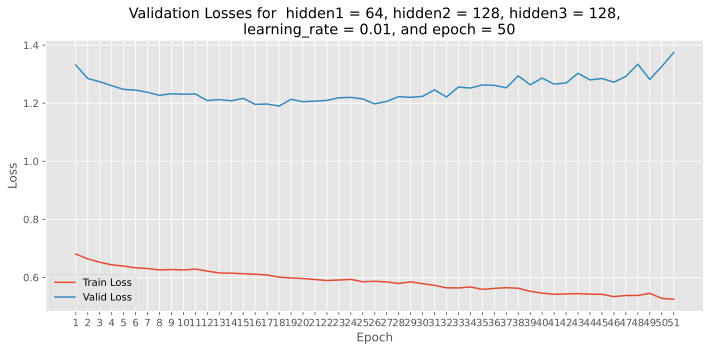

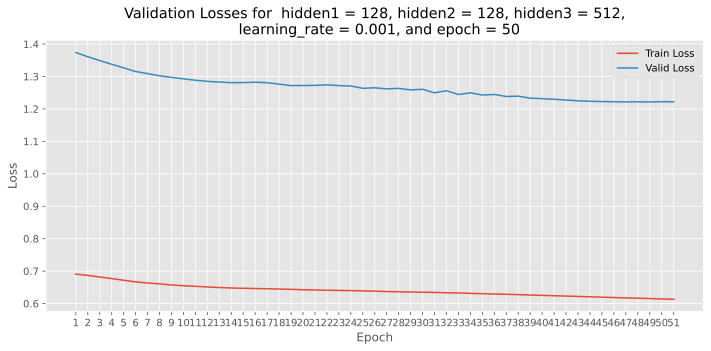

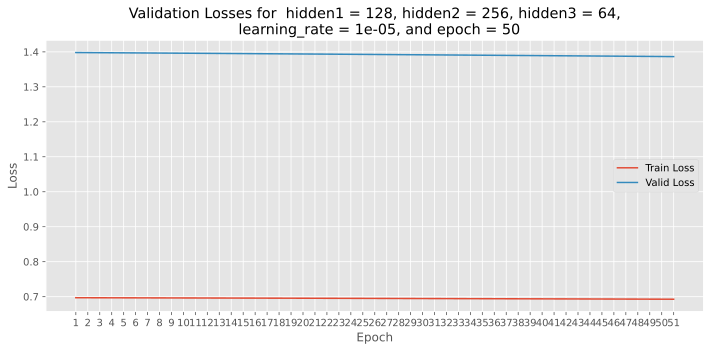

In [51]:
for i, result in enumerate(results):
    # Extract relevant information
    combination = result['combination']
    learning_rate = result['learning_rate']
    max_epochs = result['max_epochs']
    train_losses = result['train_losses']
    valid_losses = result['valid_losses']

    plt.figure(figsize=(10, 5))

    # Plot training losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.title(f'Training Losses for {combination}')
    plt.plot(range(1, len(train_losses) + 1), valid_losses, label='Valid Loss')
    plt.title(f'Validation Losses for {combination}')
    plt.xticks(range(1, len(train_losses) + 1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Explain the differences you see in the produced plots from your experiment. (3 Point)
  - What does training loss mean? (0.5 point)
  - What does validation loss mean? (0.5 point)
  - How does adding hidden layers impact the results? (0 point)
  - How do different parameters in each hidden layer impact the result? (0 point)
  - How can you evaluate a model from this training and validation graphs? Describe it in your own words. (0.5 point)
  - Can you give some intuitive explanations of overfitting and underfitting based on the graphs you produced? (0.5)
  - How does a very small and very large learning rate impact the training and
   validation loss? (1 point)


 **Your answers go here:**
 The loss in general is the deviation of the model's prediction from the target it is being compared with. You could also describe it as "negative accuaracy". In the training process this loss is measured in several iterations or epochs. The goal then is to minimize the loss during training by updating the weights and biases through backpropagation which includes gradient descent algorithms.
 The validation loss now shows how well the model generalizes to unseen data that has not been encountered during the training process. It helps for example to detect overfitting in the train dataset (sign: when train loss continues to decrease while valid loss stagnates).


# 5. Check Performance of BoW Model

<h1>Exercise 5.1</h1> (2 Points)<br> Calculate `precision`, `recall` and `f1-score` for each of the classes. As you learned in the lecture, those are common measures to define the quality of our classifier.

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [52]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.59      0.53       335
           1       0.59      0.47      0.53       414

    accuracy                           0.53       749
   macro avg       0.53      0.53      0.53       749
weighted avg       0.54      0.53      0.53       749



**Let's check a few examples!**

Checking them might help understand, what might still go wrong.

In [53]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, target_lst, text_lst))

def print_random_prediction(model, n=4, input_type='bow'):
    # prints prediction made by the model and the true value for n items.
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            probs = model([inputs])

            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [40]:
print_random_prediction(bow_model, n=20, input_type='bow')

<ipython-input-27-e82e01d8f005>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Number,Review,Predicted,Actual
1,@jazzgotsoul @liveguy lol nooooooooo!!!,😄,😄
2,"( http://NudistPoet.com ) is loving his life! Yay! ""Praise God from whom all blessings flow."" Tad is feeling so creative and inspired!",😄,😄
3,I accidentally slammed the door on one of my toes cause i thought my foot wasn't there. It did bleed but it's stopped now :/,😡,😡
4,......never drive faSter than yOur guardian angeL can fly,😄,😄
5,. @MaryRSnyder Thank you! I figured you could use the chocolate biscotti after all that shredding!,😡,😄
6,"#inaperfectworld they'd sell Fanta LimÃ³n in Guate! ....hahaha (quÃ© engase, yo sÃ© yo sÃ©)",😡,😡
7,"""This version of the iPhone software (2.2.1) is the current version"" Also, #squarespace. Just for kicks.",😡,😡
8,*Hello! So they say we're out of resection but am still broke,😡,😡
9,"#squarespace, one in a billion? more like one in infinity",😡,😡
10,"""No distance of place or lapse of time can lessen the friendship of those who are thoroughly persuaded of each other's worth.""",😄,😄


### Final task: Using the formula, calculate **precision**, **recall** and **f1-score** for the above 20 random predictions. <br> (1.5 points)

**Your answer goes here.**
- precision = True positive / (True positive + False positive)
-> precision = 4 / (4 + 0) = 1


- recall = True positive / (True positive + False negative)
-> recall = 4 / (4 + 6) = 0.4


- f1-score = 2((precision * recall) / (precision + recall))
-> f1-score = 2 * (1*0.4) / (1+0.4) = 0.57




You are done, we hope that you learned something practical in this homework! 🎄
